In [ ]:
# Google Colab Setup
try:
    from google.colab import drive
    drive.mount('/content/drive')
    import os
    import sys

    # Path to the project root in Google Drive
    project_root = '/content/drive/MyDrive/ComputerVisionTest'

    if os.path.exists(project_root):
        # Change to project root to install requirements
        os.chdir(project_root)
        print("Installing requirements...")
        !pip install -q -r requirements.txt

        # Add project root to sys.path
        if project_root not in sys.path:
            sys.path.append(project_root)
            print(f"Added {project_root} to sys.path")

        # Change directory to 'notebooks' so relative paths work
        notebooks_dir = os.path.join(project_root, 'notebooks')
        if os.path.exists(notebooks_dir):
            os.chdir(notebooks_dir)
            print(f"Changed directory to {notebooks_dir}")
    else:
        print(f"Warning: Project root {project_root} not found. Please check your Drive path.")

except ImportError:
    # Local Machine Setup
    import os
    import sys

    # Get the path to the project root (assuming running from notebooks/)
    current_dir = os.getcwd()
    if current_dir.endswith('notebooks'):
        project_root = os.path.abspath('..')
    else:
        project_root = os.path.abspath('.')

    if os.path.exists(os.path.join(project_root, 'src')):
         if project_root not in sys.path:
            sys.path.append(project_root)
            print(f"Added project root to sys.path: {project_root}")


# Model Training

This notebook handles the training of the ResNet50 model using Transfer Learning. 
It includes data loading, model initialization, validation-based early stopping, and metric logging.

In [ ]:
# --- Inlined src/data/transforms.py ---

from torchvision import transforms

from PIL import Image, ImageOps

class ResizeWithPad:
    """
    Resizes the image to the target size by maintaining aspect ratio
    and adding white padding (letterboxing) to fit the square.
    """
    def __init__(self, size, fill=(255, 255, 255)):
        self.size = size
        self.fill = fill

    def __call__(self, img):
        target_size = (self.size, self.size)
        
        # Copy image to avoid in-place modification issues
        img = img.copy()
        
        # Resize maintaining aspect ratio (thumbnail max dimension is size)
        img.thumbnail(target_size, Image.Resampling.LANCZOS)
        
        # Calculate padding
        delta_w = self.size - img.size[0]
        delta_h = self.size - img.size[1]
        
        # (left, top, right, bottom)
        padding = (delta_w // 2, delta_h // 2, delta_w - (delta_w // 2), delta_h - (delta_h // 2))
        
        return ImageOps.expand(img, padding, fill=self.fill)

def get_transforms(phase='train', image_size=640):
    """
    Returns the data transforms for the specified phase.
    
    Args:
        phase (str): 'train' or 'val'/'test'
        image_size (int): Target input size (default 640)
    """
    # ImageNet normalization stats
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    if phase == 'train':
        return transforms.Compose([
            ResizeWithPad(image_size),
            transforms.RandomRotation(30),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std)
        ])
    else:
        return transforms.Compose([
            ResizeWithPad(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std)
        ])


# --- Inlined src/data/loader.py ---

import torch
from torchvision.datasets import Flowers102
from torch.utils.data import DataLoader, Dataset

def create_dataloaders(data_dir='./src/data', batch_size=32, num_workers=2):
    """
    Creates DataLoaders for train, validation, and test sets.
    Uses the official Flowers102 splits but ensures transforms are applied.
    """
    
    # Define transforms
    train_transform = get_transforms('train')
    val_test_transform = get_transforms('val')

    # Load datasets
    # Note: Flowers102 'train' set is smaller (10 images per class), 
    # 'test' is larger (min 20 per class). 
    # Usually we merge and re-split if we want a standard larger train set, 
    # but strictly adhering to the dataset often means using its defined splits.
    # However, for better deep learning training, it's common to use 'train' + 'val' for training 
    # if the official 'train' is too small, OR just use the official splits.
    # Let's stick to official splits first as per "Data Integrity" rule implies using the dataset via torchvision.
    
    train_dataset = Flowers102(root=data_dir, split='train', download=True, transform=train_transform)
    val_dataset = Flowers102(root=data_dir, split='val', download=True, transform=val_test_transform)
    test_dataset = Flowers102(root=data_dir, split='test', download=True, transform=val_test_transform)

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, val_loader, test_loader


In [1]:
import sys
import os
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Add src to path
sys.path.append(os.path.abspath('../'))

# from src.data.loader import create_dataloaders
from src.models.base_model import get_model
from src.utils.seeds import set_seeds
from src.training.trainer import fit
from src.training.callbacks import EarlyStopping

# Set seeds for reproducibility
set_seeds(42)

Global seed set to 42


## Configuration & Hyperparameters

In [2]:
BATCH_SIZE = 32
NUM_EPOCHS = 20
LEARNING_RATE = 1e-3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cpu


## Data Loading

In [3]:
train_loader, val_loader, test_loader = create_dataloaders(data_dir='../src/data', batch_size=BATCH_SIZE)

## Model Initialization
We use ResNet50. Initially, only the final fully connected layer is trainable.

In [4]:
model = get_model(num_classes=102)
model = model.to(DEVICE)

## Training Setup
1. **Criterion**: CrossEntropyLoss (suited for multi-class classification).
2. **Optimizer**: Adam (widely used, good convergence). 
   *Note: Only optimizing `model.fc.parameters()` initially since backbone is frozen.*
3. **Scheduler**: ReduceLROnPlateau (decays LR when validation loss stalls).
4. **Early Stopping**: Stops training if no improvement for 5 epochs.

In [5]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer - ONLY parameters that require gradients
params_to_update = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.Adam(params_to_update, lr=LEARNING_RATE)

# Learning Rate Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

# Early Stopping
early_stopping = EarlyStopping(patience=5, verbose=True, path='best_model.pt')

## Training Loop

In [6]:
model, history = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    NUM_EPOCHS,
    DEVICE,
    early_stopping
)

Training on cpu


KeyboardInterrupt: 

## Training History Visualization

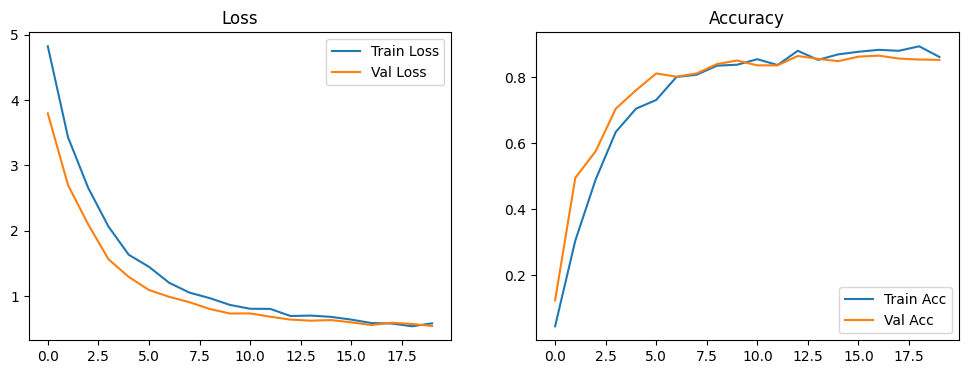

In [12]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Acc')
plt.plot(history['val_acc'], label='Val Acc')
plt.legend()
plt.title('Accuracy')

plt.show()